Let's start here! If you can directly link to an image relevant to your notebook, such as [canonical logos](https://github.com/numpy/numpy/blob/main/doc/source/_static/numpylogo.svg), do so here at the top of your notebook. You can do this with Markdown syntax,

> `![<image title>](http://link.com/to/image.png "image alt text")`

or edit this cell to see raw HTML `img` demonstration. This is preferred if you need to shrink your embedded image. **Either way be sure to include `alt` text for any embedded images to make your content more accessible.**

<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>

# Hurricane impacts in the Caribbean

---

## Overview
Extreme weather events, both atmospheric and oceanic, are increasing in frequency and intensity as a consequence of anthropogenic warming. The processes responsible for such events and their impacts on Caribbean lives remain to be well understood. Our Caribbeans for Climate community (a community of Caribbean-identified climate scientists, oceanographers, and practitioners) have created a cookbook analyzing Caribbean atmospheric and oceanic extreme weather variability from 2000-present, using Coupled Model Intercomparison Project Phase 6 (CMIP6) data. In this notebook, we execute basic statistical analysis to investigate the linkages between extreme atmospheric and oceanic heat-related events and the possible causes behind them.


1. Locate times when sea surface temperatures exceeded the 90th percentile threshold 
1. Timeseries of ENSO 3.4 index
1. Locate times of hurricanes 
1. Run basic statistics to determine any correlation between the aforementioned metrics

## Prerequisites
This section was inspired by [this template](https://github.com/alan-turing-institute/the-turing-way/blob/master/book/templates/chapter-template/chapter-landing-page.md) of the wonderful [The Turing Way](https://the-turing-way.netlify.app) Jupyter Book.

Following your overview, tell your reader what concepts, packages, or other background information they'll **need** before learning your material. Tie this explicitly with links to other pages here in Foundations or to relevant external resources. Remove this body text, then populate the Markdown table, denoted in this cell with `|` vertical brackets, below, and fill out the information following. In this table, lay out prerequisite concepts by explicitly linking to other Foundations material or external resources, or describe generally helpful concepts.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import nc_time_axis

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

## Compute Cluster

In [ ]:
from dask_gateway import Gateway
gateway = Gateway()

In [ ]:
from dask_gateway import GatewayCluster

# Create a new cluster using the GatewayCluster constructor directly
cluster = GatewayCluster()

## Load your CMIP6 data
Here, we'll load the CMIP6 model output.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [14]:
df_gfdl = df.query("activity_id=='CMIP' & table_id == 'Amon' & institution_id == 'NOAA-GFDL' & source_id =='GFDL-CM4' & experiment_id=='historical' & member_id == 'r1i1p1f1'  & variable_id == 'tas'")
df_gfdl

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
8074,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701


## Mask data outside of the Atlantic

### Compute cluster

In [6]:
import regionmask
import intake
import matplotlib.pyplot as plt
from xmip.preprocessing import combined_preprocessing
import xarray as xr
import numpy as np

<GeoAxes: >

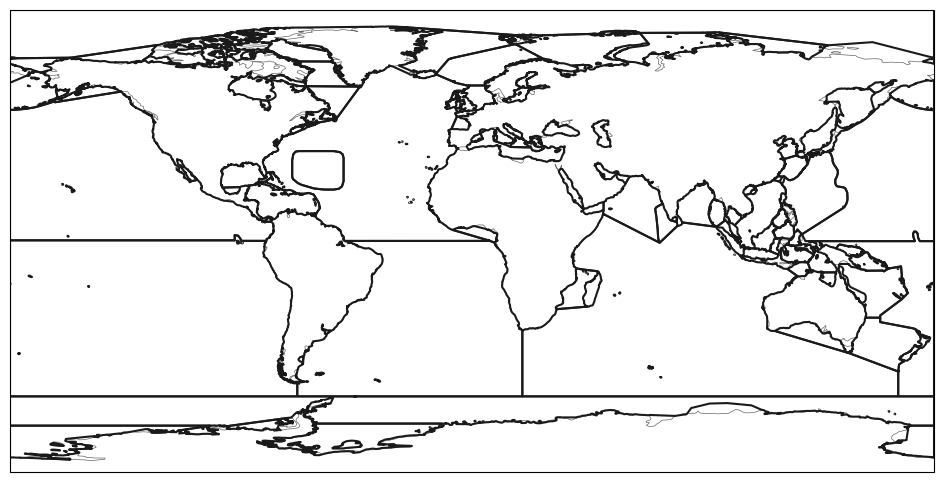

In [7]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)


In [8]:
from xmip.regionmask import merged_mask

In [15]:
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_gfdl.zstore.values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/tas/gr1/v20180701/


<xarray.Dataset> Size: 411MB
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1980)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
    height     float64 8B ...
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
Data variables:
    tas        (time, lat, lon) float32 411MB dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-07;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e4193a02-6405-49b6-8ad3-65def741a4dd...
    version_id:             v20180701

In [19]:
# Apply mask to specified data

da = ds.tas.isel(time=0).load()
mask = merged_mask(basins, da)

2024-06-12 19:04:28,988 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 385.55 MiB -- Worker memory limit: 474.75 MiB
2024-06-12 19:04:28,989 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 334.92 MiB -- Worker memory limit: 474.75 MiB
2024-06-12 19:04:29,014 - distributed.worker.memory - WARNING - Worker is at 75% memory usage. Resuming worker. Process memory: 359.16 MiB -- Worker memory limit: 474.75 MiB
2024-06-12 19:04:29,114 - distributed.worker.memory - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 431.86 MiB -- Worker memory limit: 474.75 MiB
/srv/conda/envs/notebook/lib/python3.11/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 

KeyError: 'Ross Sea Eastern Basin'

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## El Niño 3.4 idnex

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!